In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('C:/Users/DENVER/Udacity/machine-learning\projects/toxic-comment-classification/train.csv')#load the dataset
test_data = pd.read_csv('C:/Users/DENVER/Udacity/machine-learning\projects/toxic-comment-classification/test.csv')
data.head(7) # have a look at the data


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\r\n\r\nCongratulations from me as well, use ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0


In [2]:
data.shape #check how many rows are in data


(159571, 8)

In [3]:
data.isnull().any() # check for empty entries


id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [4]:
# add new column for not toxic comments
newrow = (data.iloc[:,2:].sum(axis=1)==0)
newrow.head(8)

0     True
1     True
2     True
3     True
4     True
5     True
6    False
7     True
dtype: bool

In [5]:
data['clean'] = [1 if newrow[i] else 0 for i in range(len(data))]
data['clean'].head(8)

0    1
1    1
2    1
3    1
4    1
5    1
6    0
7    1
Name: clean, dtype: int64

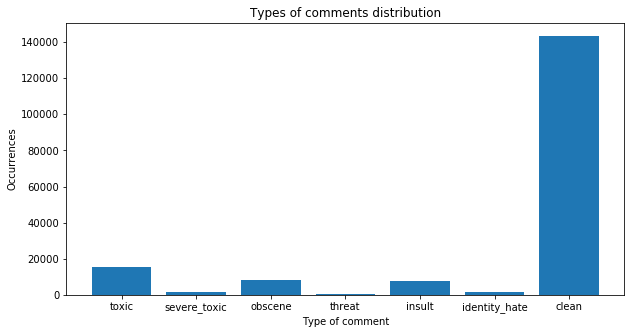

In [6]:
#visualize the data to see the distribution of the types of comments
plt.rcParams['figure.figsize'] = [10,5] # set bigger size for visualization graphs 
plt_data = (data.iloc[:,2:].sum(axis=0))
x = plt_data.index
y = plt_data.values
plt.bar(np.arange(len(x)), y)
plt.xticks(np.arange(len(x)), x)
plt.title('Types of comments distribution')
plt.xlabel('Type of comment')
plt.ylabel('Occurrences')
plt.show()


In [7]:
from keras.preprocessing.text import text_to_word_sequence
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

# function to remove stop-words, numbers, and punctuation from comments
def clean_data(data):
    clean_data = [] 
    for text in data:
        text = text_to_word_sequence(text)
        text = [word for word in text if  word.isalpha() and word not in stop_words]
        clean_data.append(text)

    return clean_data


Using TensorFlow backend.


In [8]:
from sklearn.model_selection import train_test_split

labels = ['toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
# split data into training and testing sets
comments_train, comments_test, labels_train, labels_test = train_test_split(data['comment_text'],\
                data[labels], test_size=0.2, random_state=42)


In [9]:
# clean train and test data 
comments_train = clean_data(comments_train)
comments_test = clean_data(comments_test)

#keep this ones for kaagle score
kaggle_train = clean_data(data['comment_text'])
kaggle_labels = data[['toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
kaggle_test = clean_data(test_data['comment_text'])


In [10]:
# import keras library for preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 20000  # maximum number of common wards to be considered
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(comments_train) # fit tokenizer on comments_train


In [11]:
# turn senteces into sequences 
tokenized_comments_train = tokenizer.texts_to_sequences(comments_train)
tokenized_comments_test = tokenizer.texts_to_sequences(comments_test)
tokenized_kaggle_train = tokenizer.texts_to_sequences(kaggle_train)
tokenized_kaggle_test = tokenizer.texts_to_sequences(kaggle_test)


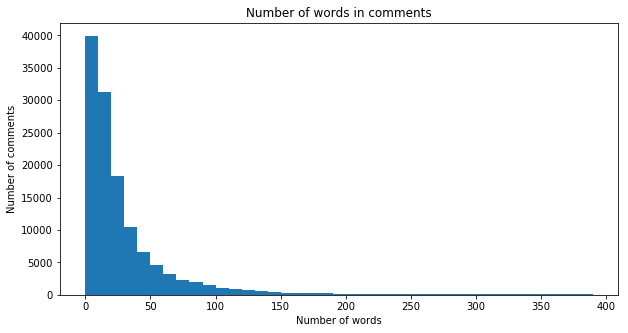

In [12]:
# visualize data to see distribution of number of  wards in comments 
senteces_length = [len(comment) for comment in tokenized_comments_train]

plt.hist(senteces_length, bins=np.arange(0, 400, 10))
plt.title('Number of words in comments')
plt.ylabel('Number of comments')
plt.xlabel('Number of words')
plt.show()

In [13]:
# turn senteces to the same lenght(maxlen)
comments_length = 150 # max length for each comment 
pad_comments_train = pad_sequences(tokenized_comments_train, maxlen=comments_length )
pad_comments_test = pad_sequences(tokenized_comments_test, maxlen=comments_length)
pad_kaggle_train = pad_sequences(tokenized_kaggle_train, maxlen=comments_length)
pad_kaggle_test = pad_sequences(tokenized_kaggle_test, maxlen=comments_length)


In [14]:
#import model and layers from keras library 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding
from keras.layers import GlobalMaxPool1D
from keras.layers import LSTM, GRU, Bidirectional

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

model = Sequential()
model.add(Embedding(max_words, 130, input_length=comments_length))
#model.add(Conv1D(filters=30,kernel_size=2, padding='same', activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(100,  dropout=0.3, recurrent_dropout=0.2,return_sequences=True)))
model.add(Bidirectional(GRU(80, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)))
#model.add(LSTM(90, dropout=0.3, recurrent_dropout=0.2, return_sequences=True))
model.add(GlobalMaxPool1D())
#model.add(Dropout(0.2))
#model.add(Dense(60, activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(6, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 130)          2600000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 200)          184800    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 150, 160)          134880    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 160)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 966       
Total params: 2,920,646
Trainable params: 2,920,646
Non-trainable params: 0
_________________________________________________________________


In [15]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback

# function to callback ROC AUC score after each epoch
class roc_auc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return


In [16]:
from keras.callbacks import ModelCheckpoint

# save weight when there is a loss improvement
checkpointer = ModelCheckpoint(filepath='weights.best.h5py', verbose=1, save_best_only=True)

#compile the model 
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

#split data to a training and validation sets (validation set is 10%)
x_val = pad_comments_train[114890:]
y_val = labels_train[114890:]
x_train = pad_comments_train[:114890]
y_train = labels_train[:114890]

#fit the data
history = model.fit(x_train,y_train, validation_data=(x_val, y_val), epochs=3, batch_size=30, verbose=1,\
          callbacks=[roc_auc_callback(training_data=(x_train,y_train),validation_data=(x_val, y_val)), checkpointer])

Train on 114890 samples, validate on 12766 samples
Epoch 1/3
114890/114890 [==============================] - 4699s 41ms/step - loss: 0.0662 - acc: 0.9786 - val_loss: 0.0523 - val_acc: 0.9804
roc-auc: 0.9811 - roc-auc_val: 0.9763                                                                                                    

Epoch 00001: val_loss improved from inf to 0.05228, saving model to weights.best.h5py
Epoch 2/3
114890/114890 [==============================] - 4750s 41ms/step - loss: 0.0470 - acc: 0.9827 - val_loss: 0.0501 - val_acc: 0.9809
roc-auc: 0.9883 - roc-auc_val: 0.9793                                                                                                    

Epoch 00002: val_loss improved from 0.05228 to 0.05008, saving model to weights.best.h5py
Epoch 3/3
114890/114890 [==============================] - 4886s 43ms/step - loss: 0.0408 - acc: 0.9843 - val_loss: 0.0515 - val_acc: 0.9809
roc-auc: 0.9924 - roc-auc_val: 0.9793                                   

In [17]:
#list all data in history
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

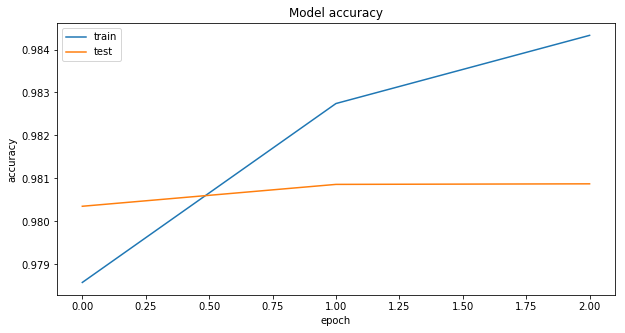

In [18]:
#summarise history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'], loc='upper left')
plt.show()

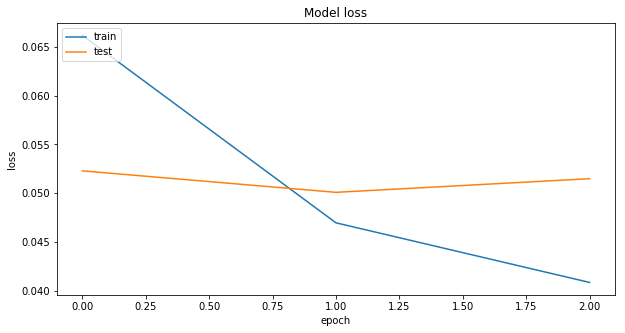

In [19]:
#summarise history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [28]:
#load the weights with the best loss value
model.load_weights('weights.best.h5py')


In [29]:
# save predictions 
pre = model.predict(pad_comments_test)


In [30]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr = [] # false positive rate for each label
tpr = [] # true positive rate for each label
roc_auc = [] # ROC AUC score for each label
for i in range(6):
    score = roc_auc_score(labels_test.iloc[:,i], pre[:,i])
    f_rate, t_rate, _ = roc_curve(labels_test.iloc[:,i], pre[:,i])
    roc_auc.append(score)
    fpr.append(f_rate)
    tpr.append(t_rate)

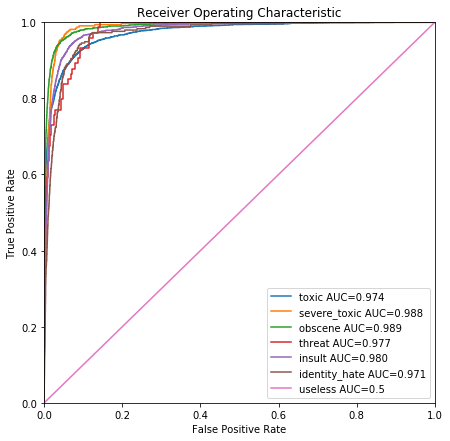

In [31]:
plt.rcParams['figure.figsize'] = [7,7] 
# plot ROC AUC for each toxicity type
for i in range(6):
    plt.plot(fpr[i], tpr[i], label=labels[i]+' AUC=%0.3f'%roc_auc[i])
plt.plot([0,1],[0,1], label='useless AUC=0.5')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [32]:
#count mean column-wise ROC AUC score    
mean_roc_auc = sum(roc_auc)/6
mean_roc_auc


0.97976834004912028

In [33]:
#save predictions for kaggle test data
predicted = model.predict(pad_kaggle_test)


In [34]:
#save predictions in pandas DataFrame
submission = pd.DataFrame(predicted, index=test_data['id'],\
                          columns=['toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

#load prediction to the submission.csv file
submission.to_csv("submission.csv")


In [35]:
#have a look how do predictions look like
submission.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,0.994555,0.446482,0.987973,0.086714,0.859173,0.186006
0000247867823ef7,0.002174,0.000082,0.000505,0.000043,0.000540,0.000121
00013b17ad220c46,0.016832,0.000704,0.004090,0.000523,0.003863,0.000909
00017563c3f7919a,0.001495,0.000036,0.000279,0.000016,0.000294,0.000065
00017695ad8997eb,0.016660,0.000402,0.002618,0.000353,0.003385,0.000727
